In [3]:
import numpy as onp
import scipy.io
from scipy.interpolate import griddata

import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu

from jax.config import config
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Architectures

In [4]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W))
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply



# Data Sampler

In [5]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# Physics-informed DeepONet

In [6]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        _, self.unravel = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define the opeartor net
    def operator_net(self, params, u, t, x):
        branch_params, trunk_params = params
        y = np.stack([t,x])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs

    def s_t_net(self, params, u, t, x):
        s_t = grad(self.operator_net, argnums = 2)(params, u, t, x)
        return s_t

    def residual_net(self, params, u, t, x):
        s_tt = grad(grad(self.operator_net, argnums = 2), argnums=2)(params, u, t, x)
        s_xx = grad(grad(self.operator_net, argnums = 3), argnums=3)(params, u, t, x)
        res = s_tt - s_xx
        return res

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_t_pred = vmap(self.s_t_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss_1 = np.mean((outputs.flatten() - s_pred)**2)
        loss_2 = np.mean(s_t_pred**2)
        loss = loss_1 + loss_2
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])
        # Compute loss
        loss_s_bc1 = np.mean((s_bc1_pred - outputs[:,0])**2)
        loss_s_bc2 = np.mean((s_bc2_pred - outputs[:,1])**2)
        loss_s_bc = loss_s_bc1 + loss_s_bc2

        return loss_s_bc

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean(pred**2)
        return loss    

    @partial(jit, static_argnums=(0,))
    def loss(self, params, ics_batch, bcs_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =  loss_ics  + loss_bcs +  loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)


    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            ics_batch = next(ics_data)
            bcs_batch = next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, bcs_batch, res_batch)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)
                
                loss_value = self.loss(params, ics_batch, bcs_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value,
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_res': loss_res_value})
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

# Data Generation

In [7]:
length_scale = 0.5
output_scale = 10.0
gp_params = (length_scale, output_scale)
c = 1.0

def RBF(x1, x2, params):
    length_scale, output_scale = gp_params 
    diffs = np.expand_dims(x1 / length_scale, 1) - \
            np.expand_dims(x2 / length_scale, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

def generate_one_gaussain_sample(key, gp_params, N):

    length_scale, output_scale = gp_params 
    jitter = 1e-10
    X = np.linspace(0.0, 1.0, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    return gp_sample

def generate_one_training_data(key, m=100, P=100, Q=100):

    subkeys = random.split(key, 5)

    # Generate one input sample
    N = 512
    gp_sample = generate_one_gaussain_sample(subkeys[0], gp_params, N)  
    x = np.linspace(0, 1, m)
    X = np.linspace(0, 1, N)[:,None]

    u_fn = lambda x: x * (1-x) * np.interp(x, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    u = vmap(u_fn)(x)

    # IC training data
    u_ic = np.tile(u, (P, 1))

    t_0 = np.zeros((P,1))
    x_0 = random.uniform(subkeys[1], (P,1))
    y_ic = np.hstack([t_0, x_0])
    s_ic = vmap(u_fn)(x_0)

    # BC training data
    u_bc = np.tile(u, (P, 1))

    t_bc1 = random.uniform(subkeys[2], (P,1))
    x_bc1 = np.zeros((P,1))

    t_bc2 = random.uniform(subkeys[3], (P,1))
    x_bc2 = np.ones((P,1))

    y_bc1 = np.hstack([t_bc1, x_bc1])
    y_bc2 = np.hstack([t_bc2, x_bc2])
    y_bc = np.hstack([y_bc1, y_bc2])

    s_bc = np.zeros((Q, 2))

    # Residual training data
    u_r = np.tile(u, (Q, 1))
    y_r = random.uniform(subkeys[2], (Q,2))
    s_r = np.zeros((Q, 1))

    return u_ic, y_ic, s_ic, u_bc, y_bc, s_bc, u_r, y_r, s_r

def generate_training_data(key, N, m, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_ic, y_ic, s_ic, u_bc, y_bc, s_bc, u_r, y_r, s_r =  vmap(generate_one_training_data, (0, None, None, None))(keys, m, P, Q)

    u_ic_train = np.float32(u_ic.reshape(N * P, -1))
    y_ic_train = np.float32(y_ic.reshape(N * P, -1))
    s_ic_train = np.float32(s_ic.reshape(N * P, -1))

    u_bc_train = np.float32(u_bc.reshape(N * P, -1))
    y_bc_train = np.float32(y_bc.reshape(N * P, -1))
    s_bc_train = np.float32(s_bc.reshape(N * P, -1))

    u_r_train = np.float32(u_r.reshape(N * Q, -1))
    y_r_train = np.float32(y_r.reshape(N * Q, -1))
    s_r_train = np.float32(s_r.reshape(N * Q, -1))
    config.update("jax_enable_x64", False)

    return  u_ic_train, y_ic_train, s_ic_train, u_bc_train, y_bc_train, s_bc_train, u_r_train, y_r_train, s_r_train


In [8]:
# Generate training data
N_train = 10000
N_test = 100
m = 100
P_train = 100
Q_train = 100

# Generate training data
key_train = random.PRNGKey(0) # use different key for generating training data 
u_ics_train, y_ics_train, s_ics_train, u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train = generate_training_data(key_train, N_train, m, P_train, Q_train)

In [9]:
# Initialize model
branch_layers = [m, 200, 200, 200, 200, 200]
trunk_layers =  [2, 200, 200, 200, 200, 200]
model = PI_DeepONet(branch_layers, trunk_layers)

In [10]:
# Create data set
batch_size = 10000
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

In [11]:
# # Train
# model.train(ics_dataset, bcs_dataset, res_dataset, nIter=200000)

In [12]:
# Save the trained model and losses
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('wave_params.npy', flat_params)
# np.save('wave_loss_res.npy', model.loss_res_log)
# np.save('wave_loss_ics.npy', model.loss_ics_log)
# np.save('wave_loss_bcs.npy', model.loss_bcs_log)
# np.save('wave_loss_test.npy', model.l2_error_log)


# Restore the trained model
params = model.unravel(np.load('wave_params.npy'))
loss_ics = np.load('wave_loss_ics.npy')
loss_bcs = np.load('wave_loss_bcs.npy')
loss_res = np.load('wave_loss_res.npy')

# Plot

In [13]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                     'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 20,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 22,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

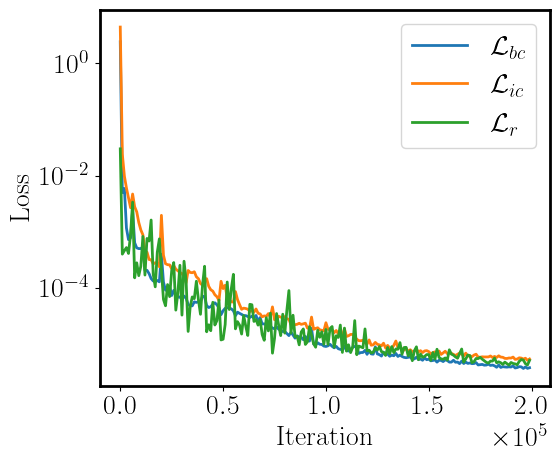

In [14]:
# Losses
fig = plt.figure(figsize = (6,5))

iters = 1000 * np.arange(len(loss_ics))
plt.plot(iters, loss_bcs, lw=2, label='$\mathcal{L}_{bc}$')
plt.plot(iters, loss_ics, lw=2, label='$\mathcal{L}_{ic}$')
plt.plot(iters, loss_res, lw=2, label='$\mathcal{L}_{r}$')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()

In [17]:
# Predicted solution
T = 100
P = 100
P_test = 100

s_fn = lambda t, x: np.sin(np.pi * x) * np.cos(np.pi * t)

x = np.linspace(0, 1, P)
u = np.sin(np.pi * x)

u_test = np.tile(u, (P**2, 1))

x = np.linspace(0, 1, P_test)
t = np.linspace(0, 1, P_test)
TT, XX = np.meshgrid(t, x)

y_test = np.hstack([TT.flatten()[:,None], XX.flatten()[:,None]])

s_pred = model.predict_s(params, u_test, y_test)
S_pred = griddata(y_test, s_pred.flatten(), (TT,XX), method='cubic')

for k in range(T-1):
    u_k = S_pred[:,-1]
    u_test_k = np.tile(u_k, (P_test**2,1 ))
    s_pred_k = model.predict_s(params, u_test_k, y_test)
    S_pred_k = griddata(y_test, s_pred_k.flatten(), (TT, XX), method='cubic')
    S_pred = np.hstack([S_pred, S_pred_k])


# Exact solution
Nx = 100
Nt = 100 * T

x = np.linspace(0, 1, Nx)
t = np.linspace(0, T, Nt)
TT, XX = np.meshgrid(t, x)

S_test = vmap(s_fn)(TT, XX)

error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 1.020e-02


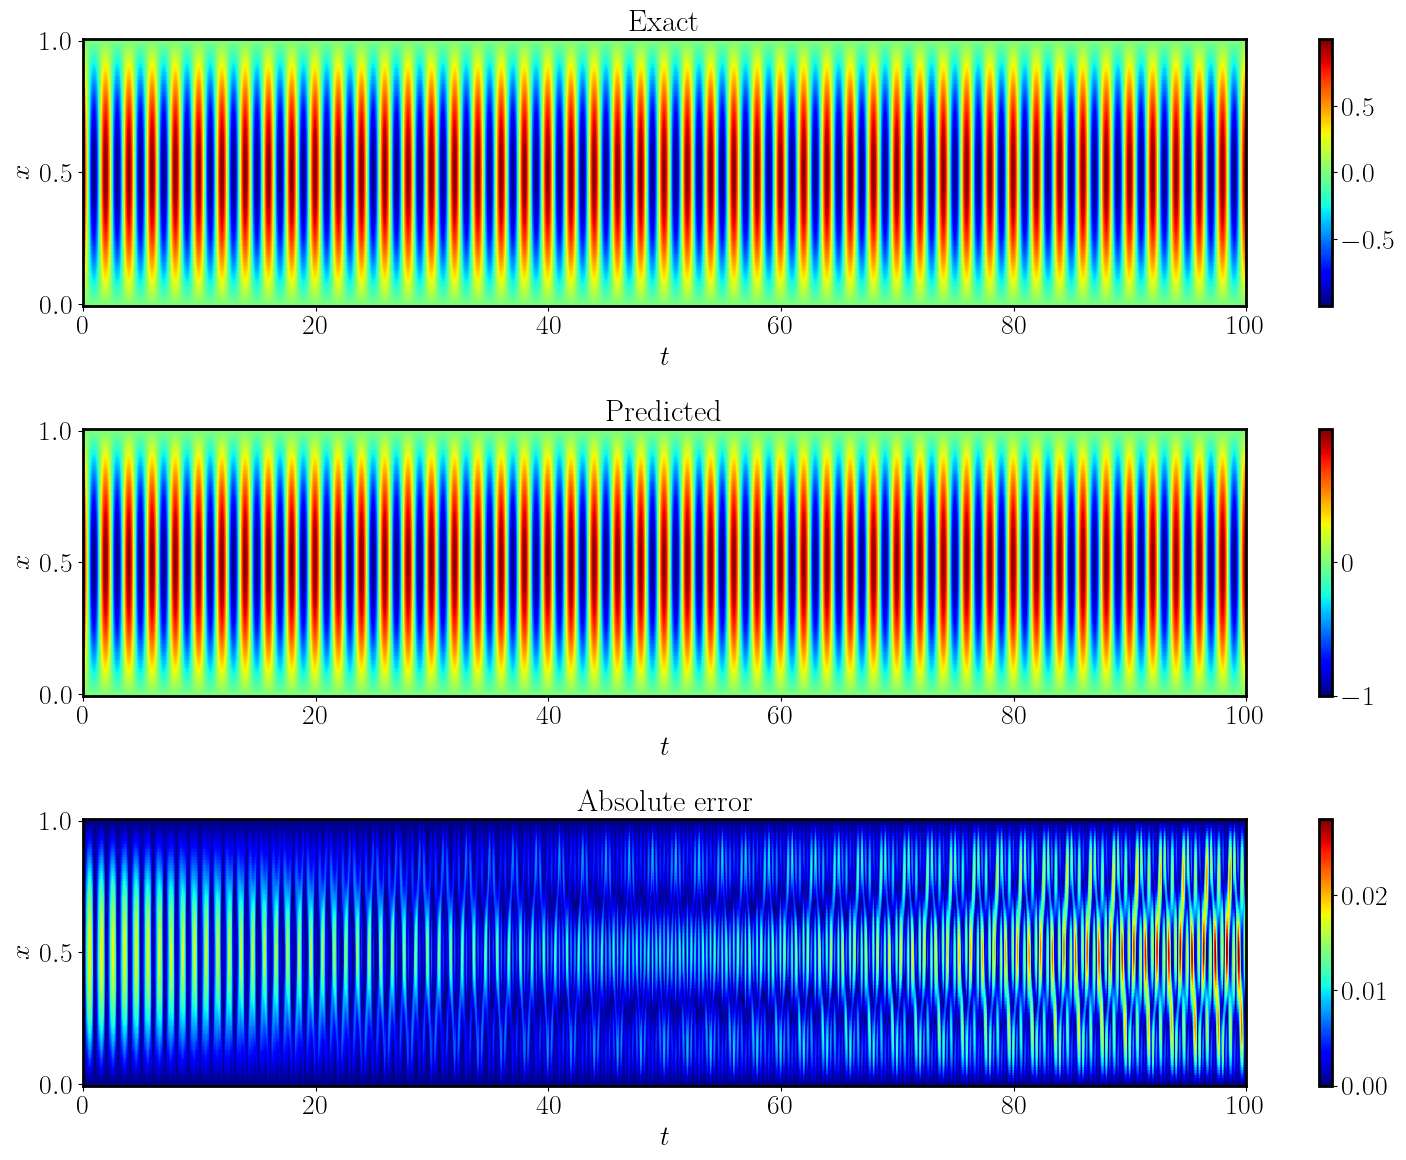

In [18]:
fig =plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.pcolor(TT, XX, S_test, cmap='jet')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact')
plt.colorbar()
plt.tight_layout()

plt.subplot(3,1,2)
plt.pcolor(TT, XX, S_pred, cmap='jet')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted')
plt.colorbar()
plt.tight_layout()

plt.subplot(3,1,3)
plt.pcolor(TT, XX, np.abs(S_pred - S_test), cmap='jet')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar()
plt.title('Absolute error')
plt.tight_layout()
plt.show()
